In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FuncAnimation, PillowWriter
from tqdm import tqdm
import pickle
np.random.seed(12345)
# %matplotlib notebook

In [ ]:
n = 25
box_l = 10
T = 1
m = 1.0

In [ ]:
# TODO modify this function to specify the initial temperature
# def initialize(beta=1.0, m=1.0):
#     xs = np.zeros([n,2])
#     for i in range(5):
#         for j in range(5):
#             xs[5*i+j, 0] = i * box_l/5 - box_l/2.0 + box_l/10.
#             xs[5*i+j, 1] = j * box_l/5 - box_l/2.0 + box_l/10.

#     vs = np.random.randn(n,2) / np.sqrt(beta * m) # temperature set here!
#     return xs, vs

# def initialize(T=1.0, m=1.0, n=25):
#     xs = np.zeros([n,2])
#     for i in range(5):
#         for j in range(5):
#             xs[5*i+j, 0] = i * box_l/5 - box_l/2.0 + box_l/10.
#             xs[5*i+j, 1] = j * box_l/5 - box_l/2.0 + box_l/10.

#     beta = 1.0 / T
#     vs = np.random.randn(n,2) / np.sqrt(beta * m)
#     return xs, vs

def initialize(T=1.0, m=1.0, n=25):
    xs = np.zeros([n,2])
    b = int(np.sqrt(n))
    for i in range(b):
        for j in range(b):
            xs[b*i+j, 0] = i * box_l/b - box_l/2.0 + box_l/2/b
            xs[b*i+j, 1] = j * box_l/b - box_l/2.0 + box_l/2/b

    beta = 1.0 / T
    vs = np.random.randn(n,2) / np.sqrt(beta * m)
    return xs, vs

In [ ]:
xs, vs = initialize(T, m, n)

In [ ]:
# helper functions for plotting
ppa = 72.*8/20
def plot_conf(xs):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(xs[:,0], xs[:,1], s=ppa**2)
    ax.set_xlim([-5,5])
    ax.set_ylim([-5,5])

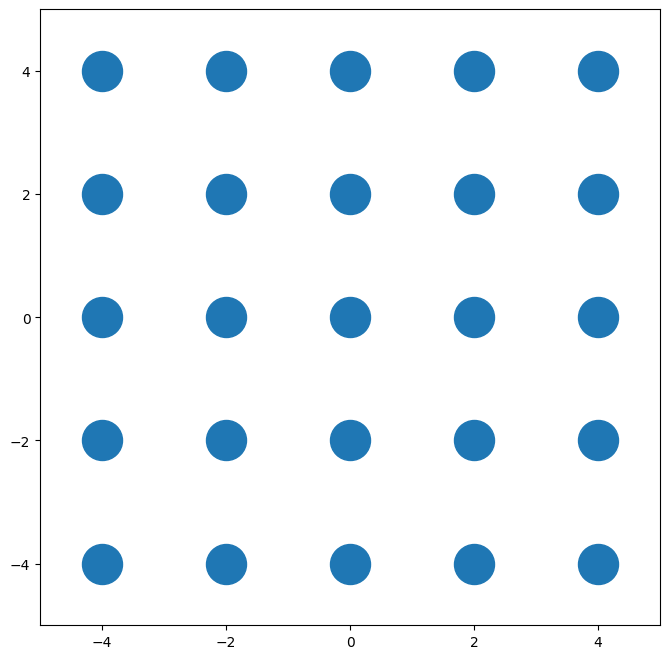

In [ ]:
plot_conf(xs)

In [ ]:
# distance function with periodic boundary conditions
def d(x0, x1):
    dxs = x1-x0
    dxs = dxs - box_l * (np.abs(dxs)>box_l/2.0) * np.sign(dxs)
    return np.sqrt( (np.sum( (dxs)**2 ) ) )

def lj_energy(xs, epsilon=1.0, sigma=1.0, r_cutoff=3.0):
    energy = 0.
    # TODO!
    for i in range(n):
      for j in range(i+1, n):
        r = d(xs[i, :], xs[j, :])
        if r > r_cutoff: continue
        energy = energy + 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)
    return energy

def lj_force(xs, box_l, epsilon=1.0, sigma=1.0, r_cutoff=3.0):
    n = len(xs)
    force = np.zeros([n, n, 2])

    for i in range(n):
      for j in range(i + 1, n):
        dxs = xs[i, :] - xs[j, :]
        dxs -= box_l * (np.abs(dxs) > box_l / 2.0) * np.sign(dxs)
        r = np.linalg.norm(dxs)

        if r > r_cutoff or r == 0: continue

        mag = 48 * epsilon * (sigma ** 12 / r ** 13 - 0.5 * sigma ** 6 / r ** 7)
        f = mag * dxs / r

        force[i, j, :] -= f
        force[j, i, :] += f

    return force

# can do both in one loop, of course
def lj_both(xs, epsilon=1.0, sigma=1.0, r_cutoff=3.0):
    energy = 0
    force = np.zeros([n, n, 2])
    # TODO
    for i in range(n):
      for j in range(i+1, n):
        # Calculate vector from i to j
        r = xs[j, :] - xs[i, :]
        r = r - box_l * (np.abs(r)>box_l/2.0) * np.sign(r)
        r_mag = np.linalg.norm(r)

        # Apply cutoff distance
        if r_mag > r_cutoff:
          continue

        # Compute energy and force
        energy = energy + 4 * epsilon * ((sigma / r_mag) ** 12 - (sigma / r_mag) ** 6)
        f_mag = 48 * epsilon * ((sigma / r_mag) ** 12 - 0.5 * (sigma / r_mag) ** 6) / r_mag
        fij = f_mag / r_mag * r # i acting on j

        force[i, j, :] = +fij # i acting on j
        force[j, i, :] = -fij # j acting on i

    return force, energy

In [ ]:
def lj_both_vectorized(xs, epsilon=1.0, sigma=1.0, r_cutoff=3.0):
    n = xs.shape[0]

    # Compute pairwise distances
    diff = xs[np.newaxis, :, :] - xs[:, np.newaxis, :]

    # Apply periodic boundary conditions if box_l is provided
    diff = diff - box_l * (np.abs(diff)>box_l/2.0) * np.sign(diff)
    r_mag = np.linalg.norm(diff, axis=2)

    # Create a mask for the upper triangle (excluding diagonal)
    mask = np.triu(np.ones((n, n), dtype=bool), k=1)

    # Apply cutoff
    cutoff_mask = (r_mag < r_cutoff) & mask

    # Compute intermediate terms
    r6_inv = (sigma / r_mag[cutoff_mask]) ** 6
    r12_inv = r6_inv ** 2

    # Compute energy
    energy = 4 * epsilon * np.sum(r12_inv - r6_inv)

    # Compute force magnitude
    f_mag = 48 * epsilon * (r12_inv - 0.5 * r6_inv) / r_mag[cutoff_mask] ** 2

    # Compute force vectors
    force = np.zeros((n, n, 2))
    force[cutoff_mask] = f_mag[:, np.newaxis] * diff[cutoff_mask]
    force = force - np.transpose(force, (1, 0, 2))

    return force, energy

In [ ]:
m = 1.
def integrate_step(xs, vs, forces, dt=5e-4):
    #TODO velocity half step
    vs_half = vs + 0.5 * dt * np.sum(forces, axis=0) / m
    #TODO position step
    xs = xs + dt * vs_half
    # correct for periodic boundary conditions after updating positions
    xs = xs - box_l * (np.abs(xs)>(box_l/2.)) * np.sign(xs)
    # force, energy = lj_both(xs)
    force, energy = lj_both_vectorized(xs)
    #TODO velocity half step
    vs = vs_half + 0.5 * dt * np.sum(force, axis=0) / m
    return xs, vs, force, energy

In [ ]:
def run_traj(xs, vs, n_steps, dt=1e-4):
    traj, Ks_list = [], []

    # Compute the initial forces
    force, energy = lj_both_vectorized(xs)

    # Run MD
    for step in tqdm(range(n_steps)):
        xs, vs, force, energy = integrate_step(xs, vs, force, dt=dt)
        traj.append(xs.copy())
        Ks_list.append(np.sum(vs ** 2)/2*m)

    return traj, Ks_list

In [ ]:
T = 5
xs, vs = initialize(T, m, n)
traj, Ks_list = run_traj(xs, vs, 5000)
with open(f"traj_T{T}", "wb") as fp: pickle.dump(traj, fp)
with open(f"Ks_T{T}", "wb") as fp: pickle.dump(Ks_list, fp)

100%|██████████| 5000/5000 [00:00<00:00, 5238.41it/s]


31.633900533041636
66.94504523150415
151.787466878742


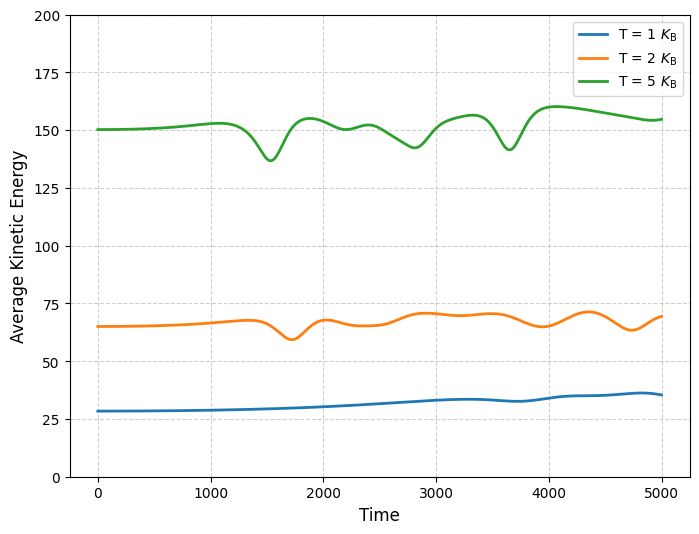

In [ ]:
# TODO compute the average kinetic energy as a function of trajectory time for T = 1kb, 2kb, 5kb
fig, ax = plt.subplots(figsize=(8, 6))

Ts = [1, 2, 5]
for T in Ts:
  with open(f"Ks_T{T}", "rb") as fp: Ks_list = pickle.load(fp)
  ax.plot(Ks_list, label=rf"T = {T} $K_{{\rm B}}$", linewidth=2)
  print(np.mean(Ks_list))
ax.set_xlabel("Time", fontsize=12)
ax.set_ylabel("Average Kinetic Energy", fontsize=12)
ax.legend()
ax.set_ylim(0, 200)
ax.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [ ]:
# TODO compute g(r) from a simulation of duration 5000 steps
T = 1
m = 1.0
n = 25
n_steps = 100000
xs, vs = initialize(T, m, n)
traj, Ks_list = run_traj(xs, vs, n_steps)

def get_inter_dists(traj):
  dists = []

  for pos in tqdm(traj, desc='Count'):
    diff = pos[np.newaxis, :, :] - pos[:, np.newaxis, :]
    diff = diff - box_l * (np.abs(diff)>box_l/2.0) * np.sign(diff)
    r_mag = np.linalg.norm(diff, axis=2)
    mask = np.triu(np.ones((n, n), dtype=bool), k=1)
    dists.append(r_mag[mask])

  return dists

def count_points_in_shell(dists, r, dr):
  count = np.sum((dists > r) & (dists < r + dr))

  return count

def compute_rdf(dists, r, dr, rho):
  n_particles = count_points_in_shell(dists, r, dr)
  volume = 2 * np.pi * r * dr

  return n_particles / (volume * rho)

# Get interatomic distances
dists = get_inter_dists(traj)
dists = np.concatenate(dists, axis=0)

rs = np.linspace(1e-3, box_l / 2.0, 1000)
rho = len(dists) / box_l ** 2
gs = []

# Count atoms
for i in tqdm(range(len(rs) - 1), desc='RDF'):
  r = rs[i]
  dr = rs[i+1] - r
  gs.append(compute_rdf(dists, r, dr, rho))

# Plot results
def lennard_jones_potential(r, epsilon, sigma):
    return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

plt.plot(rs[:-1], gs, color='black', label='Simulation')
plt.plot(rs[:-1], np.exp(-lennard_jones_potential(rs[:-1], epsilon=1.0, sigma=1.0) / T), linestyle='dotted', color='blue', label='Theory')

plt.xlabel(r"$r$")
plt.ylabel(r"$g(r)$")
plt.ylim(0, 3)
plt.legend()
plt.savefig('rdf.png')
plt.clf()

RDF: 100%|██████████| 999/999 [01:15<00:00, 13.19it/s]


<Figure size 640x480 with 0 Axes>

In [ ]:
# Compute virial coefficients from a simulation of duration 5000 steps
# integrate 2 * pi * \int_V (1 - g(r)) * r^2
dr = rs[1] - rs[0]
gs = np.array(gs)
B2_numr = np.trapz(np.pi * (1 - gs) * rs[:-1], rs[:-1])
print(f"\nNumerical virial coefficient at T={T}: {B2_numr}")

# analytical reference result
from scipy import integrate

def lennard_jones_potential(r, epsilon, sigma):
    return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

def integrand(r, T, epsilon, sigma):
    u = lennard_jones_potential(r, epsilon, sigma)
    return (np.exp(-u / T) - 1) * r

def second_virial_coefficient(T=1.0, epsilon=1.0, sigma=1.0):
    result, _ = integrate.quad(integrand, 1e-3, box_l / 2.0, args=(T, epsilon, sigma))
    return -np.pi * result

B2_annl = second_virial_coefficient(T=T, epsilon=1.0, sigma=1.0)
print(f"Analytical virial coefficient at T={T}: {B2_annl}")


Numerical virial coefficient at T=2: 0.5044482208166269
Analytical virial coefficient at T=2: 0.3531879007267355


100%|██████████| 10000/10000 [00:02<00:00, 3593.31it/s]


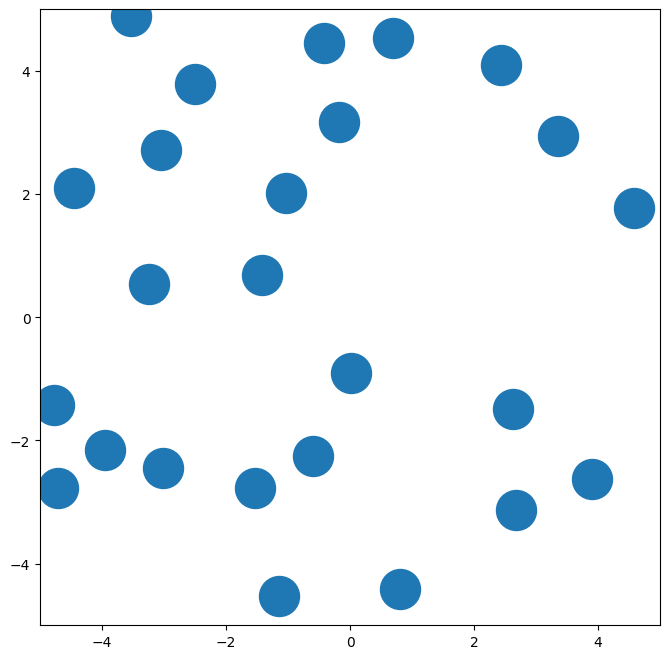

In [ ]:
T = 5
xs, vs = initialize(T, m)
traj, Ks_list, Ps_list = run_traj(xs, vs, 10000)

# set up an animation
traj_plot = [traj[i] for i in range(0, len(traj), 100)]

fig = plt.figure(figsize=(8,8))
ax = plt.gca()
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])

scat = ax.scatter(xs[:,0], xs[:,1], s=ppa**2)

def init():
    scat.set_offsets(xs)
    return scat,

def animate(i):
    scat.set_offsets(traj_plot[i])
    return scat,

anim = FuncAnimation(fig, animate, init_func=init, blit=True, interval=50, frames=len(traj_plot))
anim.save("lj_simulation.gif", writer=PillowWriter(fps=20))

In [ ]:
# Average potential energy
fig, ax = plt.subplots(figsize=(8, 6))

Ts = [1, 2, 5]
for T in Ts:
  with open(f"Ps_T{T}", "rb") as fp: Ps_list = pickle.load(fp)
  ax.plot(Ps_list, label=rf"T = {T} $K_{{\rm B}}$", linewidth=2)
  print(np.mean(Ps_list))
ax.set_xlabel("Time", fontsize=12)
ax.set_ylabel("Average Potential Energy", fontsize=12)
ax.legend()
ax.set_ylim(-20, 20)
ax.grid(True, linestyle="--", alpha=0.6)
plt.show()

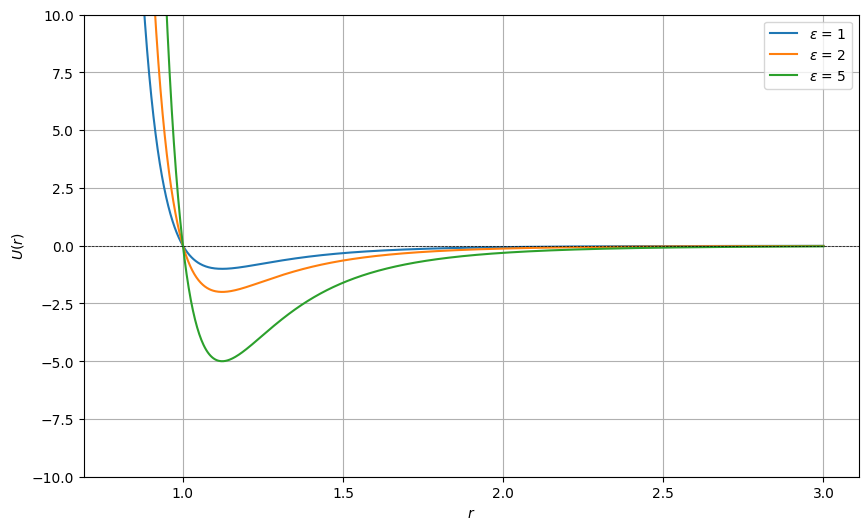

In [ ]:
# plot lennard-jones potential
def lennard_jones_potential(r, epsilon, sigma):
    return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

plt.figure(figsize=(10, 6))
r = np.linspace(0.8, 3, 1000)
sigma = 1

for epsilon in [1, 2, 5]:
    potential = lennard_jones_potential(r, epsilon, sigma)
    plt.plot(r, potential, label=rf'$\epsilon$ = {epsilon}')

plt.xlabel(r'$r$')
plt.ylabel(r'$U(r)$')
plt.legend()
plt.grid(True)
plt.ylim(-10, 10)
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
plt.show()